In [1]:
km40_dir = "/home/valeriehayot/Documents/code/SAMPLE-ICM/40km_fort"
km100_dir = None
km_40_random = "/home/valeriehayot/Documents/code/SAMPLE-ICM/40km_random"
km_40_adaptive = "/home/valeriehayot/Documents/code/SAMPLE-ICM/40km_adaptive"

In [2]:
def load_fort22(data_dir):
    import pandas as pd
    import os
    
    run_names = os.listdir(data_dir)
    df = pd.concat([pd.read_csv(os.path.join(data_dir, d, "fort.22"), delim_whitespace=True, header=2)
                    for d in run_names],
                   keys=run_names) \
           .reset_index(level=1, drop=True).rename_axis('run').reset_index()
    df['crevliq'] = df['run'].apply(lambda x: int(x.split('_')[1].strip('C')))
    df['cliffvmax'] = df['run'].apply(lambda x: int(x.split('_')[2].strip('V')))
    df = df[df['time'] != 'MARK']
    df = df.astype({'time': int, 'cliffvmax': int, 'crevliq': int})
          
    return df

def plot_timeseries(df, y_axis, trend_cols):
    from bokeh.models import ColumnDataSource
    from bokeh.plotting import figure, show, output_notebook
    from bokeh.palettes import Category20c
    import pandas as pd
    
    output_notebook()
    all_trendv = [str(col) for col in sorted(df[trend_cols[0]].unique())]
    df = df.pivot_table('esl(m)', ["time"], trend_cols)
    df.reset_index(drop=False, inplace=True)
    df = pd.DataFrame(df.to_records())
    len_param = len(all_trendv)
    
    
    data_cols = sorted([col for col in df.columns if "time" not in col and "index" not in col],
                       key=lambda x: int(x.split(',')[0].strip('(')), reverse=False)
    
    tooltip = [
        (trend_cols[0], "$name"),
        ("time", "$x"),
        ("els(m)", "$y")
    ]
    
    df = df.rename(columns={ "('time', '')": "time" })
    p = figure(plot_width=800, plot_height=500, tooltips=tooltip)
    
    for t in all_trendv:
        cols = [col_name for col_name in df.columns if t == col_name.split(',')[0].strip('(')]
        p.multi_line(xs=[list(df["time"])]*len_param,
                     ys=[df[c] for c in cols],
                     color=Category20c[len_param][int(all_trendv.index(t))],
                     legend_label=t,
                     name=t)

    p.legend.click_policy="hide"
    p.legend[0].items.reverse()
    p.add_layout(p.legend[0], 'right')
    show(p)
    
def plot_timeseries_matplotlib(df, y_axis, trend_cols):
    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import matplotlib.patches as mpatches
    import numpy as np
    import pandas as pd

    
    all_trendv = [str(col) for col in sorted(df[trend_cols[0]].unique())]
    df = df.pivot_table('esl(m)', ["time"], trend_cols)
    df.reset_index(drop=False, inplace=True)
    df = pd.DataFrame(df.to_records())
    df = df.rename(columns={ "('time', '')": "time" })

    len_param = len(all_trendv)
    
    cmap=cm.get_cmap("RdYlBu")
    colours=cmap(np.linspace(0, 1.0, len_param))[::-1]
    
    data_cols = sorted([col for col in df.columns if "time" not in col and "index" not in col],
                       key=lambda x: int(x.split(',')[0].strip('(')), reverse=False)
    
    
    fig = plt.figure(figsize=(6,4.3))
    
    for col in data_cols:
        trend_n = col.split(',')[0].strip('(')
        c3=plt.plot(df["time"],df[col],c=colours[all_trendv.index(trend_n)])
    
    legend_vals = [mpatches.Patch(color=colours[i], label=name) for i,name in enumerate(all_trendv)]
    legend_vals.reverse()
    plt.legend(handles=legend_vals, bbox_to_anchor=(1, 1))
    plt.grid()
    plt.axis('tight')
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=14)
    plt.title('Forced modern time AIS Mass Loss in Sea Level Equivalent (m)',fontsize=14)
    plt.xlabel('Year',fontsize=14)
    plt.ylabel('Sea Level Equivalent (m)',fontsize=14)
    plt.xlim([df["time"].min(), df["time"].max()])
    plt.ylim([-0.1,1.1])
    plt.show()
    
    
    
def plot_contour(df, year=500):
    import matplotlib.pyplot as plt
    import numpy as np
    
    df = df[df['time'] == year]

    fig=plt.figure()
    cliffvmax = df['cliffvmax'].unique()
    crevliq = df['crevliq'].unique()
    
    cliffvmax.sort()
    crevliq.sort()
    
    x_nparams = len(cliffvmax)
    y_nparams = len(crevliq)
    
    df = df.sort_values(by=['cliffvmax', 'crevliq'])
    
    xv, yv= np.meshgrid(cliffvmax, crevliq, indexing='ij')
    X=np.transpose([yv,xv]).reshape(x_nparams*y_nparams,2)
    
    c_range=[df['esl(m)'].min(),df['esl(m)'].max()]
    # build the colorbar
    clevels=np.linspace(c_range[0],c_range[1],11)
    
    miss=np.empty((x_nparams,y_nparams),dtype='float64')
    miss[:]=np.nan
    c1=plt.contourf(cliffvmax,crevliq,miss,clevels)
    c2=plt.scatter(X[:,1],X[:,0],c=df['esl(m)'],s=100,norm=c1.norm)
    plt.xlabel('CLIFVMAX (km/yr)')
    plt.ylabel('CREVLIQ (m per (m yr$^{−1}$)$^{2}$)')
    plt.ylim([-2.5,197.5])
    plt.xlim([-0.2,13.2])
    plt.xticks(cliffvmax)
    plt.yticks(crevliq)
    plt.colorbar(c1)
    plt.show()
    
    

In [3]:
df = load_fort22(km40_dir)
df = df[["time", "esl(m)", "crevliq", "cliffvmax"]]

# 40KM CLIFFVMAX

#### Entire parameter set

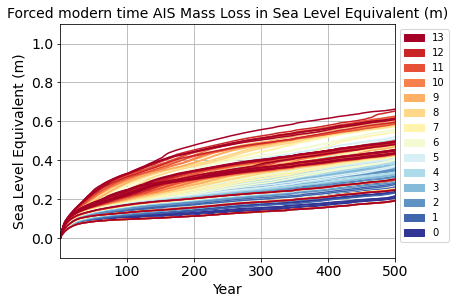

In [4]:
plot_timeseries_matplotlib(df, "esl(m)", ["cliffvmax","crevliq"])

### Random sampling

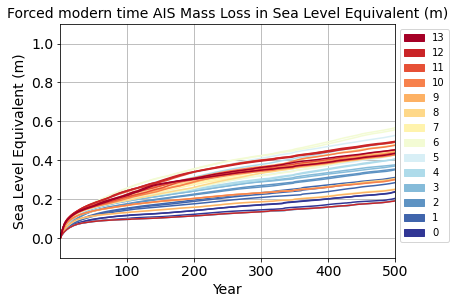

In [5]:
df_rand = load_fort22(km_40_random)
df_rand = df_rand[["time", "esl(m)", "crevliq", "cliffvmax"]]
plot_timeseries_matplotlib(df_rand, "esl(m)", ["cliffvmax","crevliq"])

### Adaptive sampling

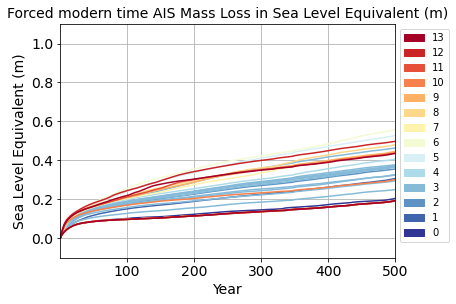

In [6]:
df_adapt = load_fort22(km_40_adaptive)
df_adapt = df_adapt[["time", "esl(m)", "crevliq", "cliffvmax"]]
plot_timeseries_matplotlib(df_adapt, "esl(m)", ["cliffvmax","crevliq"])

# 40KM CREVLIQ

#### Entire parameter set

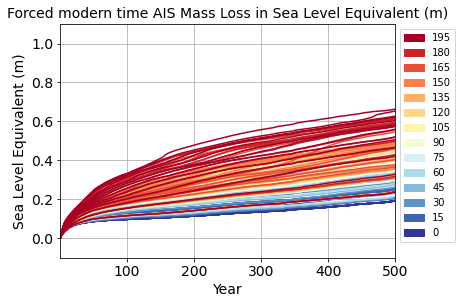

In [7]:
plot_timeseries_matplotlib(df, "esl(m)", ["crevliq", "cliffvmax"])

### Random sampling (lhs)

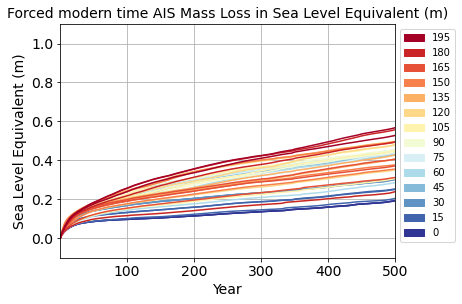

In [8]:
plot_timeseries_matplotlib(df_rand, "esl(m)", ["crevliq", "cliffvmax"])

### Adaptive sampling

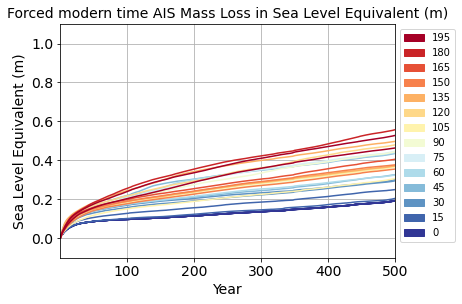

In [9]:
plot_timeseries_matplotlib(df_adapt, "esl(m)", ["crevliq", "cliffvmax"])

### Entire parameter set

/home/valeriehayot/Documents/code/SAMPLE-ICM/.venv/lib64/python3.8/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/valeriehayot/Documents/code/SAMPLE-ICM/.venv/lib64/python3.8/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


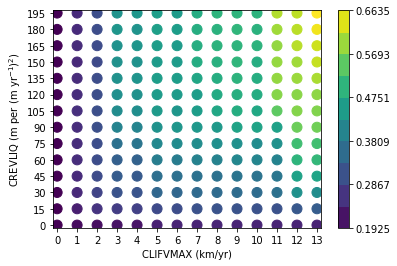

In [10]:
df = load_fort22(km40_dir)
df = df[["time", "esl(m)", "crevliq", "cliffvmax"]]
plot_contour(df)

/home/valeriehayot/Documents/code/SAMPLE-ICM/.venv/lib64/python3.8/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/valeriehayot/Documents/code/SAMPLE-ICM/.venv/lib64/python3.8/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


ValueError: 'c' argument has 40 elements, which is inconsistent with 'x' and 'y' with size 196.

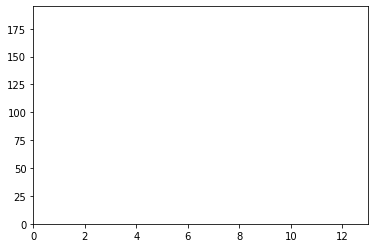

In [11]:
df = load_fort22(km_40_random)
df = df[["time", "esl(m)", "crevliq", "cliffvmax"]]
plot_contour(df)